In [1]:
!pip install huggingface_hub > /dev/null

In [ ]:
from huggingface_hub import login
login("")

## Pipeline 1: Using Direct Pretrained YOLO-V8

In [14]:
!pip install -q ultralytics huggingface_hub matplotlib opencv-python > /dev/null

In [15]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from huggingface_hub import hf_hub_download
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [16]:
image_path = 'download.png'

In [21]:
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 290MB/s]


In [22]:
results = model(image_path)


image 1/1 /content/download.png: 640x640 1 bird, 4030.2ms
Speed: 5.0ms preprocess, 4030.2ms inference, 17.3ms postprocess per image at shape (1, 3, 640, 640)


In [23]:
annotated_frame = results[0].plot()

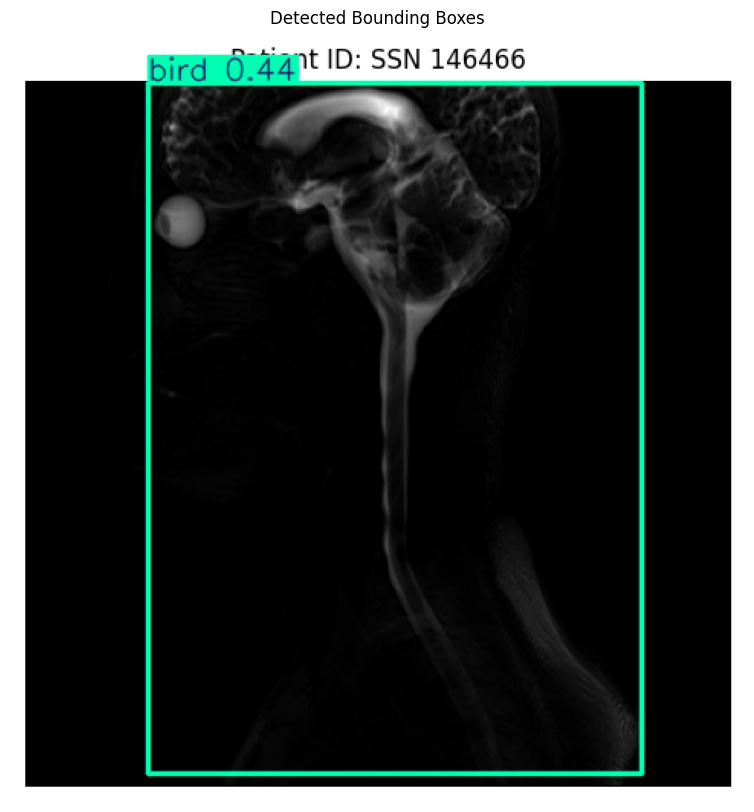

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Detected Bounding Boxes")
plt.show()

## Pipeline 2: Using VIT H

In [26]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git > /dev/null
!pip install -q opencv-python matplotlib > /dev/null

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from PIL import Image

In [28]:
image_path = "download.png"  # Make sure this file is uploaded to Colab
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [32]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [30]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth > /dev/null

In [34]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [35]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image_rgb)

In [36]:
def show_largest_mask_with_bbox(image, masks):
    if len(masks) == 0:
        print("No masks found.")
        return

    masks = sorted(masks, key=lambda x: x['area'], reverse=True)

    for i, mask_data in enumerate(masks[:3]):
        mask = mask_data['segmentation'].astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bbox_image = image.copy()

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w * h > 500:
                cv2.rectangle(bbox_image, (x, y), (x+w, y+h), (255, 0, 0), 2)

        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(bbox_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Bounding Box over Detected Region {i+1}")
        plt.axis('off')
        plt.show()

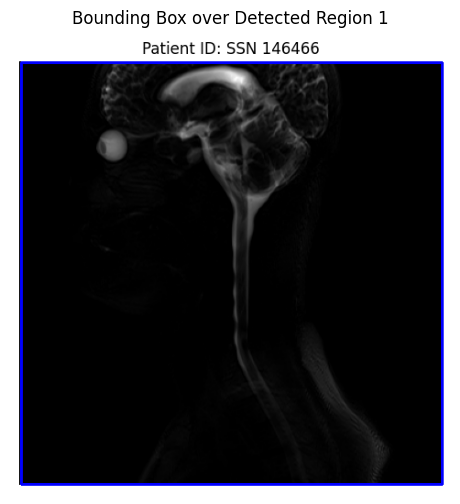

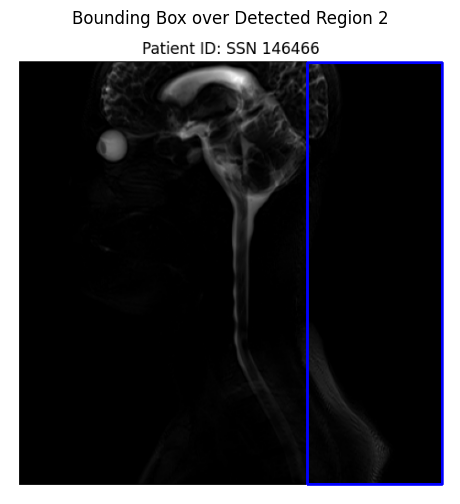

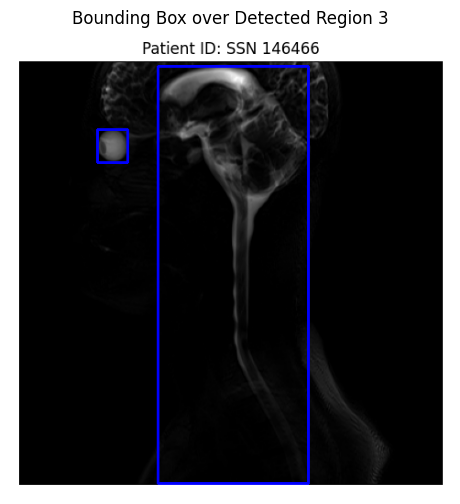

In [37]:
show_largest_mask_with_bbox(image, masks)

## Pipeline 3: Using specific brain-tumor-segmentation model using YOLOV8

In [38]:
!pip install -q ultralytics huggingface_hub > /dev/null

In [39]:
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

In [40]:
model_path = hf_hub_download(repo_id="abwahab175/Brain_tumor_segmentation_yolov8", filename="best.pt")

best.pt:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

In [41]:
model = YOLO(model_path)

In [42]:
from google.colab import files
uploaded = files.upload()

Saving download.png to download (1).png


In [43]:
results = model("download.png")


image 1/1 /content/download.png: 640x640 (no detections), 756.6ms
Speed: 4.1ms preprocess, 756.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


In [44]:
annotated_image = results[0].plot()

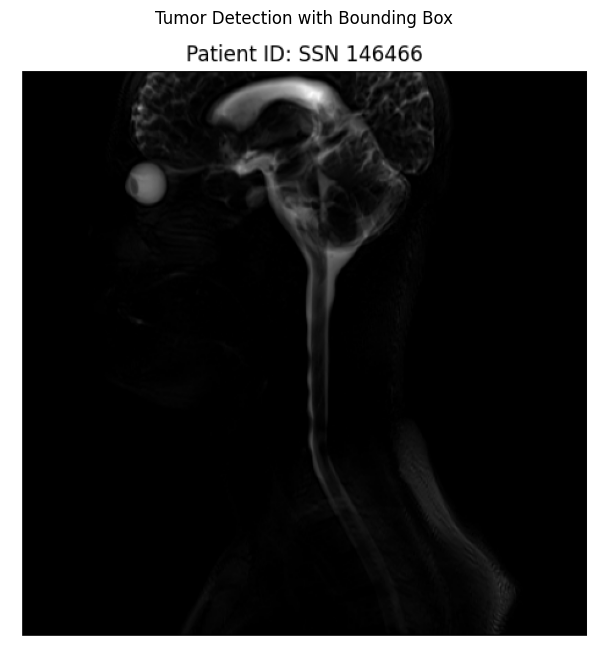

In [45]:
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("Tumor Detection with Bounding Box")
plt.axis('off')
plt.show()

## Pipeline 4: Using specific brain-tumor-segmentation model using Sam Model

In [2]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git > /dev/null
!pip install -q opencv-python matplotlib torch torchvision torchaudio > /dev/null
!pip install -q monai > /dev/null
!pip install -q timm > /dev/null

In [3]:
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

In [6]:
img_path = "download.png"
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)

In [7]:
height, width, _ = image.shape
num_points = 8
points = []
for y in np.linspace(0, height - 1, num=num_points):
    for x in np.linspace(0, width - 1, num=num_points):
        points.append([x, y])
input_points = np.array(points)
input_labels = np.ones(len(points))

In [8]:
masks, scores, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True
)

In [12]:
threshold = 0.50
combined_mask = np.zeros_like(masks[0], dtype=np.uint8)
for i, score in enumerate(scores):
    if score > threshold:
        combined_mask = np.logical_or(combined_mask, masks[i])

In [13]:
contours, _ = cv2.findContours(combined_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output_image = image.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w * h > 300:  # Ignore very small regions
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 0, 255), 2)


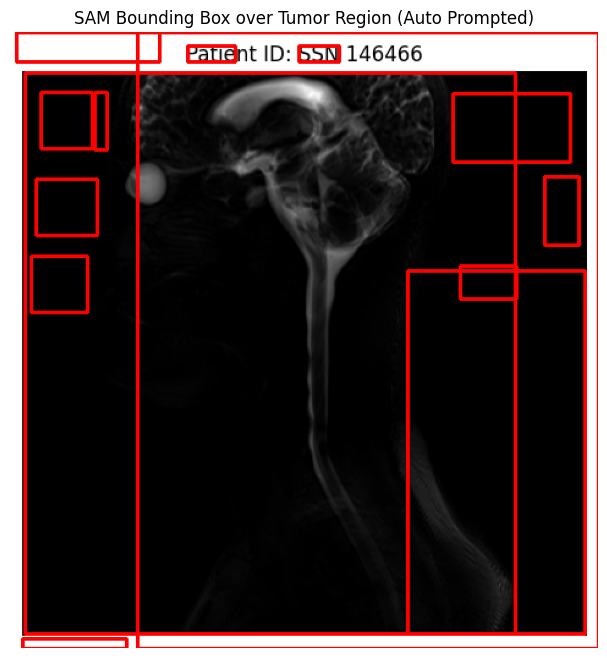

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("SAM Bounding Box over Tumor Region (Auto Prompted)")
plt.axis('off')
plt.show()

## Attempt to use a ultralytics dataset of brain tumor segmentation. 

In [18]:
!pip install -q ultralytics datasets huggingface_hub > /dev/null

In [19]:
from datasets import load_dataset
import os
from PIL import Image

# Load dataset
dataset = load_dataset("Ultralytics/Brain-tumor")

root_dir = "brain_tumor_yolo"
os.makedirs(f"{root_dir}/images/train", exist_ok=True)
os.makedirs(f"{root_dir}/labels/train", exist_ok=True)

Resolving data files:   0%|          | 0/1771 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/446 [00:00<?, ?it/s]

In [26]:
sample = dataset["train"][0]
print(sample)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512 at 0x78288E967250>}
